<h3>Team Forest<br/>
Registration Examples<br/>
CSC821, Prof. K. Okada<br/>
Spring 2022</h3>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk

import sys
import os

<h3>Creating NiFTi Images From DICOM</h3>

In [ ]:
# dicom_dir = "./LIDC-IDRI/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/"

# print("Reading Dicom directory:", dicom_dir)
# reader = sitk.ImageSeriesReader()

# dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
# reader.SetFileNames(dicom_names)

# image = reader.Execute()

# size = image.GetSize()
# print("Image size:", size[0], size[1], size[2])

# print("Writing image:", "LIDC_IDRI_axial_01.nii")

# sitk.WriteImage(image, "LIDC_IDRI_axial_01.nii")

# if ("SITK_NOSHOW" not in os.environ):
#     sitk.Show(image, "Dicom Series")

<h3>Intensity-Based Registration</h3>

In [28]:
# load fixed and moving images to register
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [29]:
def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "registered_intensity_3D.tfm")

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Intensity-Based Composition")

  0 = 524504.16406 : (-3.255615129775106, 2.323851908040856, -0.02612348128207581)
  1 = 489938.05798 : (-6.542470298055147, 4.603314059596745, -0.05133067023662149)
  2 = 452205.97909 : (-9.79413712880736, 6.932803701419525, -0.06319786983137111)
  3 = 416939.07293 : (-12.76161411445948, 9.61496881791417, -0.05479385386992799)
  4 = 402008.21773 : (-10.985549997729429, 8.695667364927838, -0.032860048884778496)
  5 = 399418.20032 : (-11.958846060734587, 8.924893475842117, -0.020605914326384638)
  6 = 392508.13118 : (-11.459455484396903, 8.903660965110012, -0.00802685422126979)
  7 = 391997.58840 : (-11.709047851419925, 8.904601948379502, 0.0062126989434687484)
  8 = 393637.68318 : (-11.584470001611326, 8.907717159856604, 0.015993025856166077)
  9 = 392361.30888 : (-11.641178011422403, 8.904091815816395, 0.04201817722665635)
 10 = 392964.07601 : (-11.610650811742476, 8.906043910869883, 0.04840894436402031)
 11 = 392639.32004 : (-11.588279340827354, 8.90756112767456, 0.07017538280170318)

In [ ]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

interact(
    display_images_with_alpha,
    image_z=(0, fixed.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed,
    moving=out,
);

<h3>Similarity 3D Transformation</h3>

In [3]:
# load fixed and moving images to register
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [4]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-4,
                                           numberOfIterations=500,
                                           gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity3DTransform())

In [5]:
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():7.5f} : {method.GetOptimizerPosition()}")

R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

Estimated Scales:  (77766.81562058833, 77150.3963728492, 135162.23070764923, 2.0227160493790284, 2.0227160493905236, 0.6399999999987221, 152999.353016389)
  0 = -0.74770 : (-0.00019472214608236242, 0.0007758282028360315, -0.00017238707743845168, -10.664098433911642, 9.296493923421538, 5.276598119545042, 1.0043824363873257)
  1 = -0.74758 : (-0.00034569158220680487, 0.0010706838821493009, -0.00012854325238347166, -11.532498289729325, 8.808882351632258, 5.186512325603588, 1.0035172272329715)
  2 = -0.75363 : (-0.0007576793537345701, 0.0017871418883573138, -0.0003395423541208101, -11.904358123481611, 8.470578119196285, 4.32209737862947, 0.9961416233972097)
  3 = -0.74785 : (-0.0007475255563833205, 0.0015940725058443848, -0.00036630216528021935, -11.64018557510421, 8.89017219030324, 4.257858774437339, 1.0013309901035186)
  4 = -0.76019 : (-0.000265957832027513, 0.0004431785000307785, -0.0004495765795756355, -11.349610186086563, 8.73972443389697, 3.879848160897685, 1.0070875807631907)
  5 =

 48 = -0.75778 : (-0.0004868686032902062, 0.0011664687402186654, -0.0012532667203823751, -11.615568008765546, 8.802382254251158, 0.759085931945206, 1.0026428160810406)
 49 = -0.75767 : (-0.0004832271077744338, 0.001175455290332879, -0.0012688524307894944, -11.561271752368771, 8.797630329572428, 0.7284986340562106, 1.0026026506955332)
 50 = -0.75778 : (-0.0004852657935296395, 0.0011699977355536166, -0.0012717438088894204, -11.588809725798589, 8.799957108130165, 0.7139106931176491, 1.0026234085890045)
 51 = -0.75773 : (-0.0004860449300397669, 0.0011695621004522224, -0.00128311219039318, -11.589643710102413, 8.799945191147444, 0.6826718341784093, 1.00262384702503)
 52 = -0.75773 : (-0.00048767053934405336, 0.0011703911648296011, -0.001294748740201535, -11.588723837390399, 8.800044039898058, 0.6514355410561791, 1.002624224128653)
 53 = -0.75772 : (-0.0004895379383649946, 0.001170492968011019, -0.0013066425234779596, -11.590065324137871, 8.7999242124903, 0.6202145869813884, 1.00262545657944

 97 = -0.75775 : (-0.0004989197763180445, 0.0011965096162494487, -0.0016300002677508698, -11.599177799589414, 8.797477721463704, -0.1587409823130053, 1.002635698000005)
 98 = -0.75773 : (-0.0004983998717382307, 0.0011984103781870156, -0.0016327060672194271, -11.592362650260778, 8.796753308444657, -0.16249118801537948, 1.002629864668669)
 99 = -0.75774 : (-0.0004983137106766896, 0.0011984156712297918, -0.001637108376150532, -11.592658962636847, 8.796768419581214, -0.17029804713476024, 1.0026299994798002)
100 = -0.75774 : (-0.000498004463313925, 0.0011988384940487932, -0.001641606487124563, -11.592447003059759, 8.79678740868588, -0.17810764294786616, 1.002629912287873)
101 = -0.75775 : (-0.0004974324775871359, 0.0011993982721036826, -0.001646108816575869, -11.592912570091235, 8.796881294494197, -0.18590568790455297, 1.002630413775688)
102 = -0.75775 : (-0.0004969160061605184, 0.001200038374744689, -0.0016507684801045487, -11.59244388431882, 8.796802064044178, -0.19370370833887857, 1.0026

146 = -0.75779 : (-0.000503764406265655, 0.0011992235628643527, -0.0017849870705520599, -11.591582890538003, 8.795211899460663, -0.3639597210047606, 1.0026314992831915)
147 = -0.75780 : (-0.000503927610898653, 0.001198761231488521, -0.0017858832969957022, -11.59329318940628, 8.795374879607984, -0.36488870228202025, 1.0026329588849636)
148 = -0.75780 : (-0.0005040083124650311, 0.0011987947345422894, -0.00178809751665127, -11.593376749049217, 8.795370000700007, -0.3668400278799088, 1.0026330904080027)
149 = -0.75780 : (-0.0005041229613892657, 0.0011987875933357726, -0.0017903577051950619, -11.59330300884725, 8.795323873407257, -0.3687912099407149, 1.0026330962143601)
150 = -0.75780 : (-0.0005042049467715037, 0.001198765526570132, -0.0017926329898154932, -11.593427340271846, 8.795332118404742, -0.37074035082995843, 1.0026332957057784)
151 = -0.75780 : (-0.0005042816382366154, 0.00119869024883515, -0.001794978325794345, -11.593271876088345, 8.795277296381025, -0.3726865010378915, 1.0026331

195 = -0.75787 : (-0.0005053315367481499, 0.0011984388826697132, -0.0018688771056849386, -11.593857805596373, 8.794798092957455, -0.4161642018771175, 1.002635508069786)
196 = -0.75787 : (-0.0005053475490047617, 0.0011985002308791141, -0.0018701464802843987, -11.593926533273356, 8.794795183035292, -0.41664760662322325, 1.0026355973002146)
197 = -0.75787 : (-0.0005053246954933417, 0.0011985865793658747, -0.0018714593409622751, -11.593882828853644, 8.794789595152295, -0.41713388879638097, 1.0026355883590712)
198 = -0.75787 : (-0.0005053424334673574, 0.0011986013647587574, -0.001872757162176601, -11.593966312928664, 8.794780064453313, -0.41761487882506676, 1.0026356713329256)
199 = -0.75787 : (-0.0005052941562287048, 0.0011986927559517345, -0.0018741226712273113, -11.593899763501563, 8.794786523379305, -0.4180985528205414, 1.0026356680571598)
200 = -0.75787 : (-0.0005053277610317266, 0.0011987339108821804, -0.0018754493809777734, -11.594030415950808, 8.794759683182766, -0.4185682559775823,

244 = -0.75786 : (-0.0005054097227851309, 0.0011997338001041343, -0.0019130349586925968, -11.594362840389778, 8.79458330279271, -0.4285965426921715, 1.0026365813133231)
245 = -0.75786 : (-0.0005054323801988444, 0.0011997632129254914, -0.0019136612561737498, -11.59439978492254, 8.794578261569857, -0.4287127720860755, 1.002636628678795)
246 = -0.75786 : (-0.0005054309179797816, 0.0011997873144685102, -0.0019143160130683265, -11.594372792192537, 8.794577109298979, -0.42883180783032826, 1.002636608238822)
247 = -0.75786 : (-0.000505430136571133, 0.00119978601618097, -0.0019149424322904094, -11.594417048916096, 8.794575901406986, -0.42894555963687897, 1.002636646943664)
248 = -0.75786 : (-0.0005054152277325248, 0.001199803934005417, -0.001915599407640129, -11.594379965254035, 8.794573366414395, -0.42906182574380375, 1.0026366195772227)
249 = -0.75786 : (-0.0005054112443386666, 0.0011997965954057414, -0.0019162073412963524, -11.59443658302822, 8.794573538884064, -0.42916996490505316, 1.00263

In [6]:
print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "registered_similarity_3D.tfm")

-------
itk::simple::Transform
 Similarity3DTransform (0x7fb14e068d00)
   RTTI typeinfo:   itk::Similarity3DTransform<double>
   Reference Count: 3
   Modified Time: 3152
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00263 0.003863 0.00240839 
     -0.00386543 1.00263 0.0010088 
     -0.00240448 -0.00101807 1.00263 
   Offset: [-11.2282, 9.01899, 0.0637135]
   Center: [14.8988, 2.93955, -173.061]
   Translation: [-11.5945, 8.79454, -0.430839]
   Inverse: 
     0.99736 -0.00384513 -0.00239185 
     0.00384271 0.997362 -0.00101273 
     0.00239574 0.0010035 0.997367 
   Singular: 0
   Versor: [ -0.000505387, 0.00120006, -0.00192703, 0.999997 ]
   Scale = 1.00264

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 271 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
 Iteration: 272
 Metric value: -0.7578561510144566


In [7]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Similarity-Based Composition")

<h3>Same Using Coronal Images</h3>

In [34]:
# load fixed and moving images to register
fixed = sitk.ReadImage("coronal_lung_window.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("MIDRC-RICORD-1A_coronal_image.nii", sitk.sitkFloat32)

In [35]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                           minStep=1e-4,
                                           numberOfIterations=500,
                                           gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity3DTransform())

In [36]:
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():7.5f} : {method.GetOptimizerPosition()}")

R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

Estimated Scales:  (159549.91317290755, 146227.91658701916, 153719.91236667268, 0.08212831833655813, 2.0227160493768808, 2.0227160493768808, 165485.19251481773)
  0 = -0.00046 : (2.6465332948649457e-05, -1.6777484869884517e-05, 3.0785497956854134e-05, -434.84669792219734, -281.2048273987524, -191.6793442971687, 0.9997742631165594)
  1 = -0.00084 : (5.4100741809217027e-05, -3.337495428734658e-05, 5.850657974652498e-05, -432.8467215261659, -281.19623041646815, -191.67482314110268, 0.999531096832105)
  2 = -0.00137 : (8.228873395705646e-05, -4.938601812879217e-05, 8.2527995223093e-05, -430.8467522647948, -281.1881268013181, -191.6672591972593, 0.9992756870575225)
  3 = -0.00203 : (0.00011131833845311484, -6.518333984631151e-05, 0.00010421363529379774, -428.8467967565722, -281.1806819340603, -191.65619308874668, 0.9990035221657736)
  4 = -0.00279 : (0.0001418278118030588, -8.139288479909817e-05, 0.0001250826820743031, -426.8468665496694, -281.173769527385, -191.6409848440496, 0.99870531303

 48 = -0.00719 : (0.007824170252391812, -0.00672816839640421, 0.008631154724630146, -418.8946669292604, -283.04706480003296, -186.8109223805491, 0.929751927576905)
 49 = -0.00716 : (0.007916064452222656, -0.006801307650263967, 0.00872376670386251, -418.9326068573223, -283.0765231627235, -186.77093841655, 0.9292938344382581)
 50 = -0.00714 : (0.008007849698828402, -0.006874455660799389, 0.008816016880473423, -418.97067832421, -283.10600751697, -186.73109882597635, 0.9288420281421266)
 51 = -0.00712 : (0.008101459834870805, -0.006949113039805203, 0.008909991319501109, -419.00756890788, -283.13605832430574, -186.69057742248938, 0.9283870714356066)
 52 = -0.00710 : (0.008194066186558135, -0.007023055440631401, 0.009002652317328903, -419.04520790711877, -283.165891610372, -186.6505868940372, 0.9279422373704809)
 53 = -0.00708 : (0.008287290379549402, -0.007097594033415727, 0.009095489380661478, -419.08247529563874, -283.1959388995211, -186.61040897525018, 0.9275000501744096)
 54 = -0.00705 

 98 = -0.00622 : (0.012859428430347585, -0.010885509506990472, 0.013402781725345701, -420.5274827125513, -284.71688790872435, -184.74488389683316, 0.9111547191968283)
 99 = -0.00621 : (0.012968358778966016, -0.010979251994105479, 0.013501244707651367, -420.55439222143906, -284.75424965436457, -184.7026225265784, 0.9108658799034941)
100 = -0.00619 : (0.013077016875590115, -0.01107292540518245, 0.01359933992247711, -420.5816338438945, -284.7915849161993, -184.66055091586875, 0.9105813995261248)
101 = -0.00617 : (0.013185936742789794, -0.01116699144114494, 0.013697536667131388, -420.6086115387003, -284.8290918095618, -184.61846188958702, 0.9102997554366689)
102 = -0.00616 : (0.013297097458305056, -0.01126316163679348, 0.013797580319965686, -420.6330339968406, -284.86745062906937, -184.5755878004133, 0.9100160943006874)
103 = -0.00615 : (0.013407804381295785, -0.011359104139110301, 0.013897081972478924, -420.6579897555564, -284.9057455406342, -184.53296437137942, 0.9097374473439765)
104 = 

148 = -0.00560 : (0.018476747830307297, -0.015907754741869645, 0.01831631155929959, -421.5496465614443, -286.780508915565, -182.6421300064528, 0.900174089205191)
149 = -0.00559 : (0.018589262300171067, -0.016011870896954467, 0.01841182457005335, -421.5644671156138, -286.8251063970149, -182.60092914361726, 0.9000188048469505)
150 = -0.00558 : (0.018701545410483814, -0.01611588396059582, 0.018507040620670635, -421.5793784904099, -286.8697607806026, -182.5598227762653, 0.8998658346307938)
151 = -0.00557 : (0.018813424161660257, -0.01621964130444198, 0.018601813371618505, -421.5947790947465, -286.91439226118985, -182.51887219022638, 0.8997153360678192)
152 = -0.00557 : (0.018925124819577803, -0.016323360011477158, 0.018696332887914665, -421.61018942243226, -286.95908757233605, -182.477994933291, 0.8995669119189926)
153 = -0.00556 : (0.01903681737269583, -0.016427196699277537, 0.01879072893080103, -421.6252487765277, -287.0039119778286, -182.43712822025122, 0.8994202998380555)
154 = -0.0055

198 = -0.00524 : (0.02390455568869253, -0.02104991899184879, 0.022811008185637402, -422.17163426897383, -289.1043910853899, -180.65034997415685, 0.8945035463489697)
199 = -0.00523 : (0.02400845421678884, -0.021150134312151105, 0.022895118288523447, -422.1813570156705, -289.1526408812653, -180.61183300136528, 0.894423665645154)
200 = -0.00522 : (0.024112030682194665, -0.02125007559804576, 0.022978949058502115, -422.1913859869012, -289.2009004567878, -180.57340689374644, 0.8943448435942459)
201 = -0.00522 : (0.024215418871351715, -0.021349877612953906, 0.023062545897574026, -422.20123929765754, -289.24922782879526, -180.5350205603027, 0.8942669784881426)
202 = -0.00521 : (0.024318511415918908, -0.021449430852213333, 0.02314587681860449, -422.2113286020759, -289.29756892983136, -180.49671288651314, 0.8941900910668282)
203 = -0.00521 : (0.024421335443641685, -0.021548761958762104, 0.023228947565459297, -422.2214895960254, -289.34594865465226, -180.45847297118257, 0.8941141297320513)
204 = 

248 = -0.00498 : (0.028817817420243075, -0.025789633646618116, 0.026741187861944158, -422.6073165286824, -291.565229089928, -178.77497496553673, 0.8914494442228313)
249 = -0.00498 : (0.028910353906779825, -0.02587760120864706, 0.02681423804842887, -422.61492179017955, -291.61505780044155, -178.73802336539632, 0.8914034894006798)
250 = -0.00497 : (0.02900267289792543, -0.025965242157486388, 0.02688707765328307, -422.62243135401286, -291.66490167023323, -178.70107263072933, 0.8913579424973954)
251 = -0.00497 : (0.02909479905422494, -0.02605257221300737, 0.026959722037709934, -422.6297688433935, -291.71476357005037, -178.6641116457885, 0.8913128485148327)
252 = -0.00496 : (0.029186688897291056, -0.02613954668820388, 0.027032110107946018, -422.63726662493616, -291.7646065926182, -178.62715736059258, 0.8912681875481512)
253 = -0.00496 : (0.02927842269037772, -0.026226239745520533, 0.02710434307076905, -422.6444166496708, -291.8144798918258, -178.59017500762528, 0.8912239529843579)
254 = -0.

298 = -0.00485 : (0.033216506498220805, -0.029719968891037122, 0.0301520320002981, -422.93269605954, -294.0459159195747, -176.90302681876338, 0.8895941574488879)
299 = -0.00485 : (0.03330043333279625, -0.029787184678514614, 0.030215696455726047, -422.93795884982615, -294.0949966369729, -176.86469181292563, 0.8895640679401875)
300 = -0.00485 : (0.03338416178410826, -0.029853835420755398, 0.030279154580712883, -422.94367449884584, -294.14401373401654, -176.82634024763246, 0.8895341612455899)
301 = -0.00485 : (0.03346780762082832, -0.029920006174434723, 0.030342483249064252, -422.9489420307564, -294.1930261383149, -176.7879185776273, 0.8895044307884883)
302 = -0.00485 : (0.03355135237260194, -0.029985673781758267, 0.030405656259509528, -422.95391187380744, -294.2420212413715, -176.74943522597536, 0.8894749062701478)
303 = -0.00485 : (0.033634713541261484, -0.03005076942949777, 0.030468639476372777, -422.9592429325149, -294.29096052420465, -176.71092919065504, 0.889445571488041)
304 = -0.0

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "similarity_coronal_3D.tfm")

In [ ]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "ImageRegistration2 Composition")

<h3>3D Rigid Registration</h3>

In [3]:
OUTPUT_DIR = "./"

# Actually read the data based on the user's selection.
fixed_image = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving_image = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

# Save images to file and view overlap using external viewer.
sitk.WriteImage(fixed_image, os.path.join(OUTPUT_DIR, "fixedImage.mha"))
sitk.WriteImage(moving_image, os.path.join(OUTPUT_DIR, "preAlignment.mha"))

MetaImageIO (0x7fe46c09d800): Unsupported or empty metaData item ITK_FileNotes of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe46c09d800): Unsupported or empty metaData item aux_file of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe46c09d800): Unsupported or empty metaData item descrip of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe46c09d800): Unsupported or empty metaData item intent_name of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe46c07a600): Unsupported or empty metaData item ITK_FileNotes of type NSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEEfound, won't be written to image file

MetaImageIO (0x7fe46c07a600): Unsupported or empty metaData item aux_file

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [17]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=66, description='image_z', max=132), FloatSlider(value=0.5, description=…

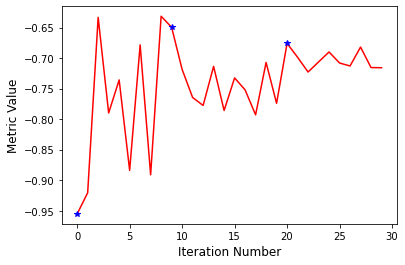

In [16]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [18]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

Final metric value: -0.6802881713366341
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.


<h4>Output Registered Images With Sliders</h4>

In [19]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=66, description='image_z', max=132), FloatSlider(value=0.5, description=…

In [20]:
sitk.WriteTransform(
    final_transform, os.path.join(OUTPUT_DIR, "registered_rigid.tfm")
)

<h3>Gaussian Interpolator Using Bins</h3>

In [6]:
#!/usr/bin/env python

import SimpleITK as sitk
import sys
import os

def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")

In [29]:
fixed = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

In [30]:
numberOfBins = 24
samplingPercentage = 0.10

# numberOfBins = 10
# samplingPercentage = .2

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(numberOfBins)
R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetOptimizerAsRegularStepGradientDescent(1.0, .001, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkGaussian)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

# sitk.WriteTransform(outTx, "registration_gaussian_3D.tfm")
sitk.WriteTransform(outTx, "registration_nearestNeighbor_3D.tfm")

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Gaussian Axial 3D Registration")

  0 =   -0.41089 : (-0.4026207971128648, 0.8754286673258748, -0.26743436981106994)
  1 =   -0.42109 : (-0.7768247020334567, 1.7595792175059417, -0.547165029836863)
  2 =   -0.43072 : (-1.2391968836512444, 2.5905631495108636, -0.8564831030489645)
  3 =   -0.44091 : (-1.834057454253525, 3.32412249945711, -1.1851646839888916)
  4 =   -0.45206 : (-2.4534448452741273, 4.018765372284992, -1.550993249131252)
  5 =   -0.46340 : (-3.1052068517358924, 4.645931845215021, -1.977453683597853)
  6 =   -0.47438 : (-3.8224347941134975, 5.178870115679044, -2.4264090026972065)
  7 =   -0.48578 : (-4.519220635558451, 5.7155141653075585, -2.902331953562319)
  8 =   -0.49726 : (-5.314296497478809, 6.05681516325232, -3.4036980898275333)
  9 =   -0.50924 : (-6.063311104538768, 5.4885050184666655, -3.7442868414687505)
 10 =   -0.51503 : (-6.440147897755347, 4.952409279586254, -4.499664488763474)
 11 =   -0.51535 : (-6.296650822526109, 5.408680969958009, -4.645351598577472)
 12 =   -0.51737 : (-6.4621693548066

<h3>Rigid 3D Transform</h3>

In [68]:
fixed = sitk.ReadImage("coronal_lung_window.nii", sitk.sitkFloat32)
moving = sitk.ReadImage("MIDRC-RICORD-1A_coronal_image.nii", sitk.sitkFloat32)

In [74]:
def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMeanSquares()
R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)
tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(tx)
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, "registered_rigid_3D.tfm")

if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Rigid Registration Composition")

  0 = 647536.07472 : (-2.2126663207618233, 2.9046615276337695, 1.6260801839808474, -464.2361866815595, -268.9782432259103, -205.7907103202919)
  1 = 518846.52151 : (-6.025051047955461, 2.875747553805901, 2.8363926907738097, -464.23904321765684, -268.97715189579424, -205.79528842894172)
  2 = 608255.29580 : (-4.2957102439122945, 1.8778643991393262, 2.951642473477969, -464.22607621797465, -268.9780503504364, -205.80786341956434)
  3 = 433557.37505 : (-4.346392826973249, 0.24465149934958585, 1.7988071252617626, -464.22697664624275, -268.9461839742271, -205.80673075275664)
  4 = 623957.28270 : (-3.4854912454967195, 0.3667624321740229, 2.2925713217985306, -464.23736368815133, -268.94357809302113, -205.80230084780442)
  5 = 686176.12855 : (-3.667591880206655, 0.8195967597510925, 2.401052722898747, -464.23457100936685, -268.9424735181197, -205.80408888608412)
  6 = 615543.28485 : (-3.6231057261903796, 0.5823595141119414, 2.3359615430108907, -464.23313683827024, -268.9418947718973, -205.804555

<h3>Landmark Based Registration</h3>

In [12]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

import os
import numpy as np

from ipywidgets import interact, fixed
%run update_path_to_download_script

%matplotlib notebook
import gui

# This is the registration configuration which we use in all cases. The only parameter that we vary 
# is the initial_transform. 
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return (final_transform, registration_method.GetMetricValue())


In [55]:
fixed_image = sitk.ReadImage("LIDC_IDRI_axial_01.nii", sitk.sitkFloat32)
moving_image = sitk.ReadImage("2.000000-ROUTINE CHEST NON-CON-50599.nii", sitk.sitkFloat32)

clean_window_level = [1727,-320]
covid_window_level = [1727,-320]

<IPython.core.display.Javascript object>


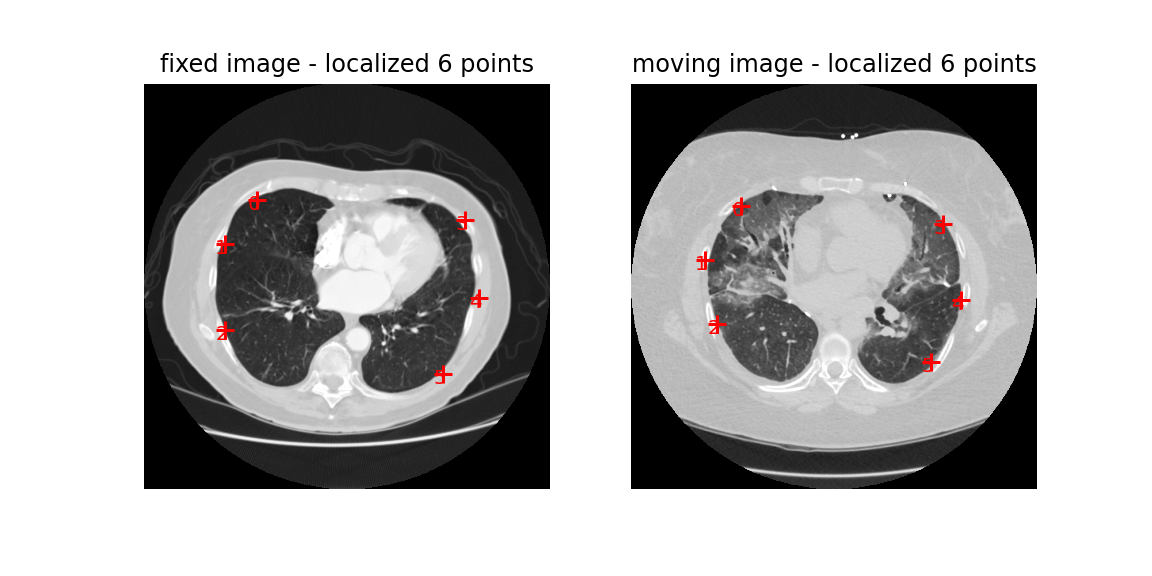

In [62]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), fixed_window_level=clean_window_level, moving_window_level=covid_window_level);

In [57]:
fixed_image_points, moving_image_points = point_acquisition_interface.get_points()

In [58]:
fixed_image_points_flat = [c for p in fixed_image_points for c in p]        
moving_image_points_flat = [c for p in moving_image_points for c in p]
initial_transformation = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                fixed_image_points_flat, 
                                                                moving_image_points_flat)


In [59]:
final_transform,_ = multires_registration(fixed_image, moving_image, initial_transform)

Final metric value: -0.597642144247761
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 13.


In [60]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
# sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.mha'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'covid_axial_landmark_based.tfm'))

In [61]:
if ("SITK_NOSHOW" not in os.environ):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    # resampler.SetTransform(outTx)

    out = resampler.Execute(moving_image)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(moving_resampled), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    sitk.Show(cimg, "Landmark Composition")